In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/MyDrive/4-2MachineLearning/CNN과제/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
import os


In [ ]:
# 이미지의 폴더경로
image_dir = Path('/content/drive/MyDrive/4-2MachineLearning/CNN과제/Images')
# filepaths : 모든 이미지들의 경로
filepaths = list(image_dir.glob(r'**/*.jpg'))
# 각 파일 경로에서 라벨을 추출, '/' 로 분할하여, 상위 폴더(라벨)을 추출
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
# 파일의 경로와 라벨을 pandas series로 변환, 저장
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
# 파일 경로와, 라벨을 하나의 데이터 프레임으로 합침
image_df = pd.concat([filepaths, labels], axis=1)
# 데이터 프레임을 셔플
# 모든 행들이 무작위로 섞임
image_df = image_df.sample(frac=1).reset_index(drop = True)
# 인덱스를 섞은후 처음부터 0으로 다시 라벨링 해줌
# train set 과, test set을 split, test set의 크기는 0.9, random seed 는 10
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=10)

In [ ]:
train_df.shape

(275, 2)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

In [ ]:
# 데이터 전처리, ImageDataGenerator 는 데이터 증강 함수임
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # 픽셀의 값을 0~1 로 rescaling // 정규화, 경사하강법의 안정성, 오버플로우 및 언더플로우 방지, 알고리즘의 수렴성 향상을 꾀함1
    rescale=1./255,
    # 이미지를 수평으로 뒤집는 데이터 증강
    horizontal_flip=True,
    # 이미지를 무작위로 회전 / -40도 ~ 40도
    rotation_range=40,
    # 이미지를 무작위로 가로로 이동 / 이미지 폭의 ~ 20%
    width_shift_range=0.2,
    # 이미지를 무작위로 세로로 이동 / 이미지 높이의 ~ 20%
    height_shift_range=0.2,
    # 이미지를 무작위로 변형
    shear_range=0.2,
    # 이미지를 무작위로 확대
    zoom_range=0.2,
    # validation set는 train set의 20%
    validation_split=0.2
)
# 테스트 데이터의 이미지를 전처리 한느 ImageDataGenerator를 생성
# train data는 증강처리까지 하고, test data는 스케일링만 실행
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [ ]:
# train data 제너레이터를 생성
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # 훈련 데이터 지정
    x_col='Filepath', # 이미지 파일 경로가 저장된 열
    y_col='Label', # 라벨 정보가 저장된 열
    target_size=(224, 224), # 이미지 크기 조정
    color_mode='rgb', # 컬러이미지 rgb 사용
    class_mode='categorical', # 다중 클래스 분류 -> categorical
    batch_size=32, # 미니 배치 사이즈 지정
    shuffle=True, # 데이터 무작위로 섞기
    seed=30, # 난수 발생시드
    subset='training'# 훈련데이터 서브셋을 사용 , 훈련데이터 생성
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # 훈련 데이터 프레임 지정
    x_col='Filepath', # 이미지 파일 경로 지정
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=30,
    subset='validation' #'validation' 서브셋을 사용하여 검증 데이터 생성
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df, # 테스트 데이터프레임 지정
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False, # 데이터를 섞지 않음, test와 다름
    seed = 30 # 난수 발생 시드
)

Found 220 validated image filenames belonging to 2 classes.
Found 55 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


In [ ]:
train_images.class_indices

{'Carrots': 0, 'Rockets': 1}

In [ ]:
# 이미지 분류를 위한 사전 훈련된 VGG16 모델을 가져옴
from tensorflow.keras.applications import VGG16
pretrained_model = VGG16(
    input_shape=(224, 224, 3),  # 입력 이미지의 크기와 채널 수를 지정함
    include_top=False,         # Fully Connected Layer를 포함하지 않도록 설정
    weights='imagenet'         # 사전 학습된 가중치를 사용
)

# VGG16 모델의 모든 레이어를 동결
for layer in pretrained_model.layers:
    layer.trainable = False


pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of VGG: output shape:', last_layer.output_shape)
last_output = last_layer.output


last layer of VGG: output shape: (None, 7, 7, 512)


In [ ]:

# Fully Connected Layer를 추가하여 새로운 모델을 구성
x = tf.keras.layers.Dropout(0.2)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [ ]:
# 새로운 모델을 정의합니다.
model_vgg = tf.keras.Model(pretrained_model.input, outputs = outputs)

# 모델을 컴파일합니다.
model_vgg.compile(
    optimizer='adam',  # 최적화 알고리즘과 학습률을 설정
    loss='categorical_crossentropy',  # 손실 함수를 설정
    metrics=['accuracy']  # 평가 지표를 설정
)



In [ ]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
checkpoint_path = 'models/models/Myvggmodel.h5'

callbacks = [
    # 손실(cal_loss)을 모니터링, 손실이 10 에폭 동안 줄어들지 않으면,훈련 조기 종료
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    # ReduceLROnPlateau 콜백: 검증 데이터의 손실(val_loss)을 모니터링하며, 손실이 5 에폭 동안 감소하지 않으면 학습률을 0.1배로 감소시킴.
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    # ModelCheckpoint 콜백: 검증 데이터의 손실(val_loss)을 모니터링하며, 손실이 가장 낮을 때 모델의 가중치를 저장, 모델의 가중치만 저장하지 않음
    # 가장 좋은 성능을 보인 모델만 저장
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
# 모델을 fit 하기 시작
history = model_vgg.fit(
    train_images, # train image를 사용
    validation_data=val_images, # validation 은 val_image 사용
    epochs=20, # 20에포크 실행
    callbacks=callbacks # 콜백 함수 리스트
)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 2.9996 - accuracy: 0.5864
Epoch 1: val_loss improved from inf to 0.07262, saving model to models/models/Myvggmodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 14s 1s/step - loss: 2.9996 - accuracy: 0.5864 - val_loss: 0.0726 - val_accuracy: 0.9636 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.8409
Epoch 2: val_loss did not improve from 0.07262
7/7 [==============================] - 6s 807ms/step - loss: 0.5677 - accuracy: 0.8409 - val_loss: 0.2000 - val_accuracy: 0.9455 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8909
Epoch 3: val_loss did not improve from 0.07262
7/7 [==============================] - 6s 815ms/step - loss: 0.3823 - accuracy: 0.8909 - val_loss: 0.1634 - val_accuracy: 0.9636 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9409
Epoch 4: val_loss did not improve from 0.07262
7/7 [==============================] - 6s 816ms/step - loss: 0.2238 - accuracy: 0.9409 - val_loss: 0.1850 - val_accuracy: 0.9455 - lr: 0.0010
Epoch 5/20
7/7 [=

In [ ]:
results = model_vgg.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0])) # 테스트 데이터의 손실(loss) 출력
print("Test Accuracy: {:.2f}%".format(results[1] * 100)) # 테스트 데이터의 정확도 출력

    Test Loss: 0.17636
Test Accuracy: 90.32%


In [ ]:
pred = model_vgg.predict(test_images) # test 데이터 예측 시작
pred = np.argmax(pred,axis=1) # 각 예측에 대해, 확률값이 가장 높은 클래스의 인덱스 선택

labels = (train_images.class_indices) # 클래스 레이블 사이의 매핑을 가져옴
labels = dict((v,k) for k,v in labels.items()) # 매핑된 클래스 레이블을 딕셔너리로 변환
pred = [labels[k] for k in pred] # 예측된 클래스 인덱스를 클래스 로 변환

1/1 [==============================] - 0s 494ms/step


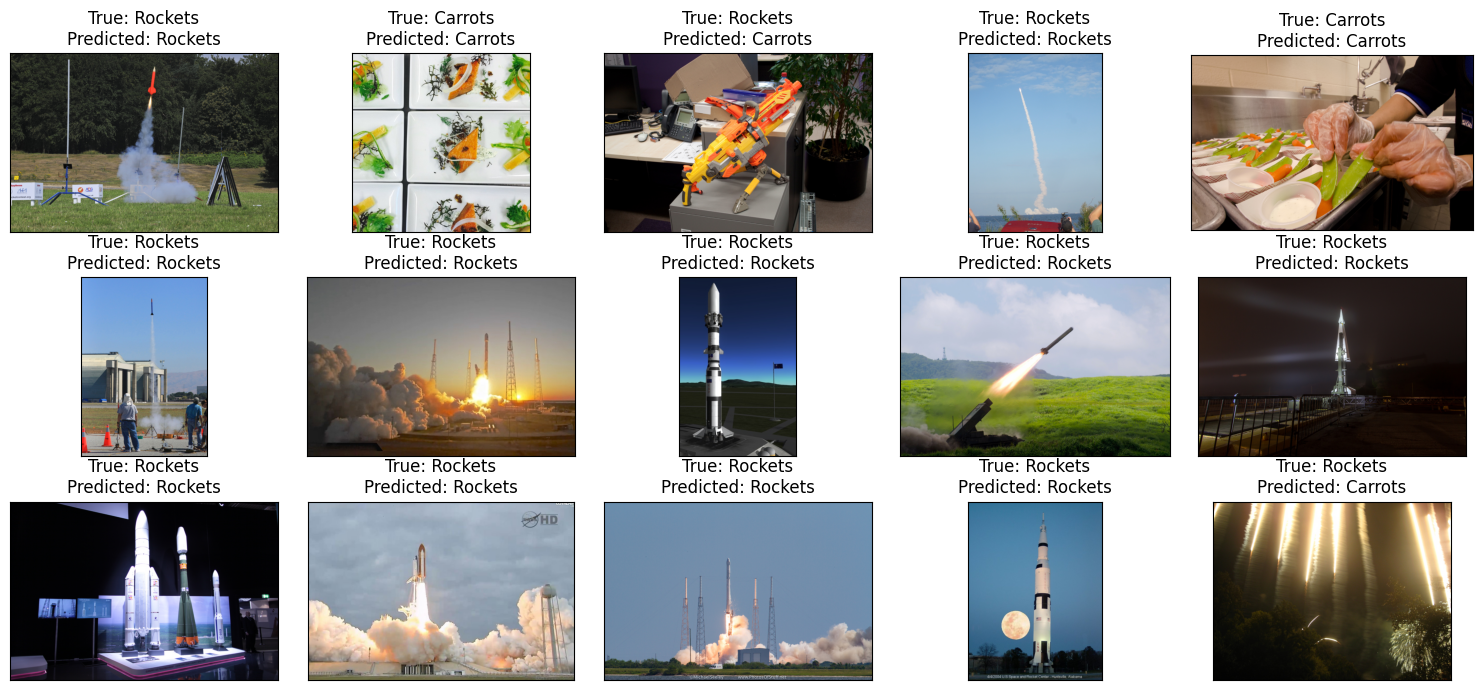

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

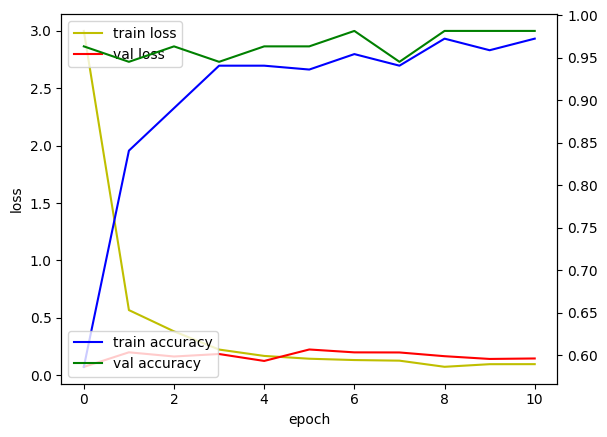

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
# 손실 그래프 그리기
loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')
# 정확도 그래프 그리기
acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')
# x축과 y축에 레이블 추가
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
# 손실과 정확도에 대한 범례 추가.
loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)  # 실제 테스트 데이터의 클래스 레이블을 리스트로 가져옴
print(classification_report(y_test, pred)) # 분류 모델의 성능 보고서 출력

              precision    recall  f1-score   support

     Carrots       0.70      1.00      0.82         7
     Rockets       1.00      0.88      0.93        24

    accuracy                           0.90        31
   macro avg       0.85      0.94      0.88        31
weighted avg       0.93      0.90      0.91        31



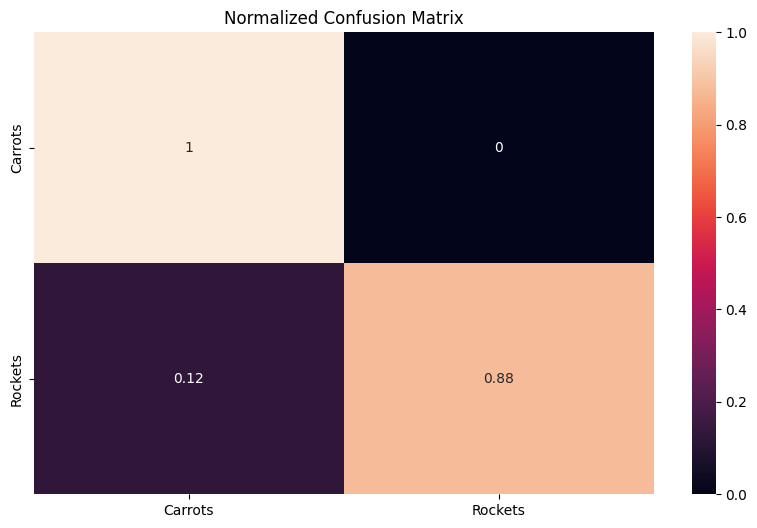

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true') # 혼동 행렬을 계산.
plt.figure(figsize = (10,6)) # 크기 선택
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test))) # 히트맵으로 시각화
plt.title('Normalized Confusion Matrix') # 제목
plt.show()